In [1]:
# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [2]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pickle
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  

cuda:0


In [4]:
data_dir= ''
model_name = "resnet"# "alexnet", "densenet", 'vgg', 'resnet'
num_classes = 10
batch_size = 1
num_epochs = 15
feature_extract = True

In [5]:
class GTZANDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx][0]
        y = self.data[idx][1]
        
        if self.transform:
            x = self.transform(x)
        
        x = torch.Tensor(x)

        return (x, y)

In [6]:
batch_size = 5


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

GTZAN_data = pickle.load(open('data/GTZAN_resized.train', 'rb'))
trainset = GTZANDataset(GTZAN_data)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

GTZAN_data = pickle.load(open('data/GTZAN_resized.test', 'rb'))
testset = GTZANDataset(GTZAN_data)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)


In [7]:
# dataloaders_dict = {'train': trainloader, 'test':testloader}

In [8]:
# [resnet, alexnet, vgg, squeezenet, densenet]

In [9]:
def train_model(model, dataloaders,criterion, opt,epochs):
    since = time.time()
    avg_loss = []
    best_model_wts = copy.deepcopy(model.state_dict())
    avg_acc = []
    print_freq = 100
    model = model.cuda()
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        running_loss = 0.0
        running_acc = 0.0


        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            opt.zero_grad()
             # forward
            # track history if only in train
            
            outputs = model(inputs)
            _, preds = torch.max(outputs,1)
            loss = criterion(outputs, labels)

            loss.backward()
            opt.step()
        # statistics
            running_loss += loss.item() 
            running_acc += torch.sum(preds == labels.data)
#             scheduler.step()
            if i % print_freq == print_freq - 1: # Print every several mini-batches.
                losses = running_loss / print_freq
                acc = running_acc / (print_freq*batch_size)
                print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}, acc: {:.3f}'.format(
                    epoch, i, losses, acc))
                avg_loss.append(losses)
                avg_acc.append(acc)
                running_loss = 0.0
                running_acc = 0.0
            # deep copy the model
            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))

    """this is only useful if we want to combine training and eval states"""
    # load best model weights
#     model.load_state_dict(best_model_wts)
    return model, avg_loss

In [10]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg16_bn(pretrained=use_pretrained)
        
        """this is uncomment if we want to freeze the inner layer"""
        # freeze inner layer
#         for param in model_ft.parameters():
#             param.requires_grad = False  # will this cause a problem for the first layer?
        
        model_ft.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224 # what does it mean?
    
    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
#         set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.features[0] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
        model_ft.features[12] = nn.MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224 
    
    elif model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
#         set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /tmp/xdg-cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 20.4MB/s]


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
model_ft = model_ft.to(device)

In [12]:
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001,momentum=0.9)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train and evaluate
model_ft,avg_loss = train_model(model_ft, trainloader, 
                             criterion, optimizer_ft, epochs=num_epochs)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

In [13]:
torch.save(model_ft.state_dict(), 'resnet_on_GTZAN_resized_batchsize_5_epoch_15.pt')

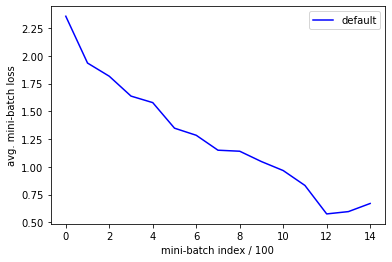

In [14]:
plt.plot(avg_loss, 'b', label='default')
print_freq = 100
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.legend()
plt.show()

### evaluation

In [15]:
# Get test accuracy.
correct_net = 0
correct_cnn = 0
total = 0
with torch.no_grad():
    
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs_cnn = model_ft(images)

        _, predicted_cnn = torch.max(outputs_cnn.data, 1)
        total += labels.size(0)

        correct_cnn += (predicted_cnn == labels).sum().item()


print('pre_trained: Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct_cnn / total))

pre_trained: Accuracy of the network on the 10000 test images: 42 %


In [16]:
classes = ('blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock')
truths = []
preds = []
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        if type(c) is not list:
            c = [c]
#         print ("outside: ", c)
#         print ("separate: ", c[0][0])
#         print ("separate: ", c[1])
#         print ("separate: ", c[2])
        for i in range(batch_size):
            preds.append(predicted[i].item())
            
            truths.append(labels[i].item())

            label = labels[i]
            class_correct[label] += c[0][i]
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of blues : 42 %
Accuracy of classical : 63 %
Accuracy of country : 39 %
Accuracy of disco : 29 %
Accuracy of hiphop : 53 %
Accuracy of  jazz : 66 %
Accuracy of metal : 84 %
Accuracy of   pop : 25 %
Accuracy of reggae : 26 %
Accuracy of  rock : 48 %
